In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import naludaq
print(f"Naludaq version: {naludaq.__version__}")

Naludaq version: 0.31.7


In [35]:
from naludaq.backend import DiskAcquisition

ACQ_PATH = "data/SineWave_100MHz/"
channels = 4
# DiskAcquisition is recommended to be used as a context manager for safety
with DiskAcquisition(ACQ_PATH) as acq:
    print("Board model:", acq.params["model"])
    print("Number of events:", len(acq))
    print("Pedestals stored:", acq.pedestals is not None)

acq= DiskAcquisition(ACQ_PATH)

from naludaq.tools.pedestals.pedestals_correcter import PedestalsCorrecter
pedestals=acq.pedestals
params = acq.params
corrector = PedestalsCorrecter(params, pedestals)

Board model: dsa-c10-8
Number of events: 1013
Pedestals stored: True


This is all assuming the starting cell is correct, which is everything but sure

In [36]:
num_cells = 128
cell_data = {i: [] for i in range(num_cells)}  # Initialize storage for each cell

for ev_num in range(len(acq)):
    event=acq[ev_num]
    corrected_event = corrector.run(event, correct_in_place=True)
    time=corrected_event["time"]
    time=(time[4] - time[4][0]) * 0.1 
    start_window = event['start_window'] % num_cells 
    adc_values=corrected_event["data"]   
    
    for i in range(1024):
        cell = (start_window + i) % num_cells  # Compute actual cell index
        cell_data[cell].append(adc_values[4][i])  
        

# cell_offset = []
# for i in range(128):
#     cell_offset.append(np.median(cell_data[i]))

# for cell in range(num_cells):
#     cell_data[cell] = np.array(cell_data[cell]) - cell_offset[cell] 

[ 0.  12.8 25.6 38.4 51.2 64.  76.8 89.6]


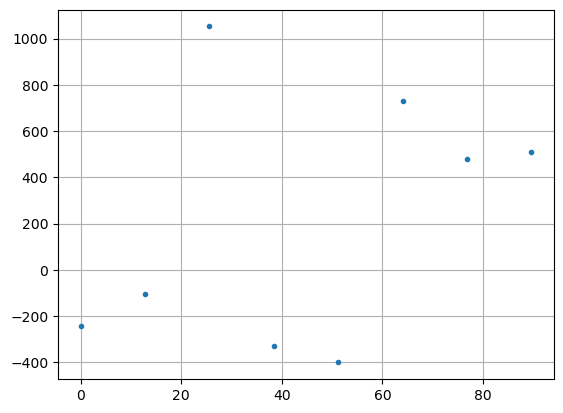

In [37]:
time_0 = np.arange(0, 8 * 12.8, 12.8)
print(time_0)
# cell 1, event 0
plt.plot(time_0, cell_data[0][0:8],'.')      # cell_data[event][0-7 is first cell and so on]
# plt.plot(time_0, cell_data[0][8:16],'.')      # cell_data[event][0-7 is first cell and so on]
plt.grid()

2648.8
Offset: 356.04999999999995


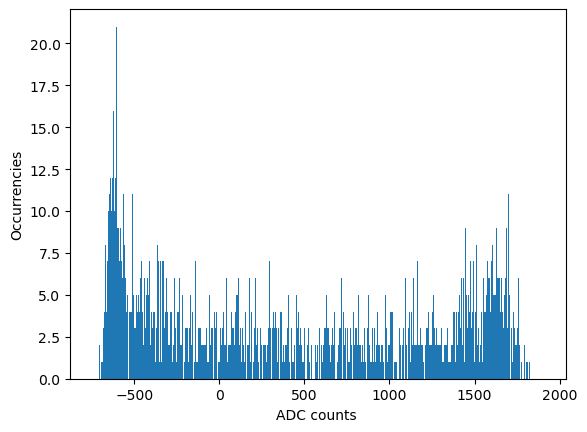

In [38]:
print(np.max(cell_data[1]) - np.min(cell_data[1]))

plt.hist(cell_data[1],bins=2649);
plt.xlabel("ADC counts ")
plt.ylabel("Occurrencies")
print('Offset:', np.median(cell_data[1]))

* Look for an event that has got a point on the offset

In [ ]:
# Convert cell_data[1] to a NumPy array (if not already)
cell_1_data = np.array(cell_data[1])  # Shape: (8104,)

# Find the indices where ADC count is 348
indices_offset = np.where((cell_1_data >= 356) & (cell_1_data < 357))[0]

# Each event consists of 8 points, so compute the event index for each
event_indices = indices_offset // 8  # Integer division to find the event number

# Print results
print(f"Total occurrences of ADC 348: {len(indices_offset)}")
print(f"Indices in cell_data[1]: {indices_offset}")
print(f"Corresponding event indices: {event_indices}")
    

Total occurrences of ADC 348: 5
Indices in cell_data[0]: [1281 1899 3350 4651 5559]
Corresponding event indices: [160 237 418 581 694]


### This is an example of an event like the ones we would like

356.0


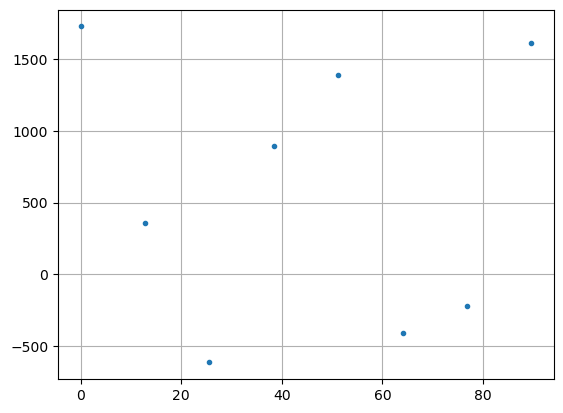

In [60]:
time_0 = np.arange(0, 8 * 12.8, 12.8)
print(cell_data[1][1281])
plt.plot(time_0, cell_data[1][event_indices[0]*8:event_indices[0]*8+8],'.')      # cell_data[event][0-7 is first cell and so on]
# plt.plot(time_0, cell_data[0][8:16],'.')      # cell_data[event][0-7 is first cell and so on]
plt.grid()

* Let's try to fit this

Fitted parameters: A=1195.239, f=0.100, phi=1.474, C=467.548
1662.1087156168599
1728.6


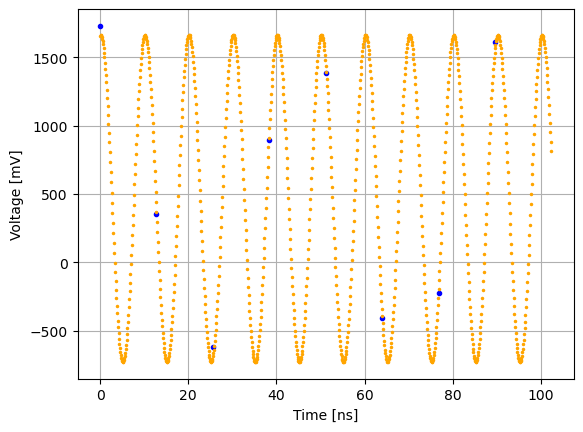

In [61]:
def sinewave(x, A, f, phi, c):
    return A * np.sin(2 * np.pi * f * x + phi) + c

p, _ = curve_fit(sinewave, time_0, cell_data[1][event_indices[0]*8:event_indices[0]*8+8], p0=[2500, 0.1, 0, 0])

A_fit, f_fit, phi_fit, C_fit = p
print(f"Fitted parameters: A={A_fit:.3f}, f={f_fit:.3f}, phi={phi_fit:.3f}, C={C_fit:.3f}")

plt.plot(time_0, cell_data[1][event_indices[0]*8:event_indices[0]*8+8],'.', color='blue', label="Data")
plt.plot(time, sinewave(time, *p),'.',markersize=3,color = 'orange', label="Fit")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]");
plt.grid()

print(sinewave(time,*p)[1])
print(cell_data[1][1280])

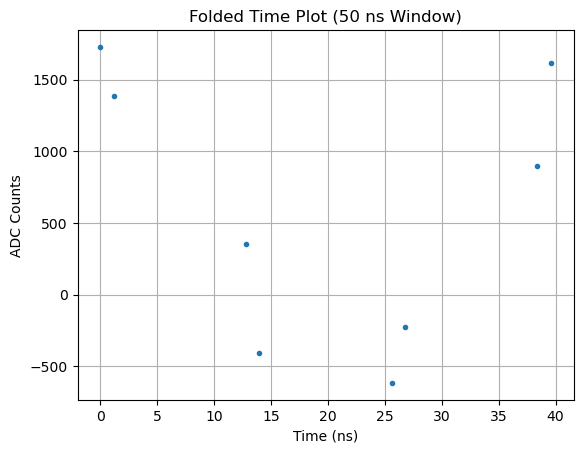

In [62]:
time_0_folded = (np.arange(0, 8 * 12.8, 12.8)) % 50  # Fold time into a 50 ns window

plt.plot(time_0_folded, cell_data[1][event_indices[0] * 8 : event_indices[0] * 8 + 8], '.')
plt.grid()
plt.xlabel("Time (ns)")
plt.ylabel("ADC Counts")
plt.title("Folded Time Plot (50 ns Window)")
plt.show()

Fitted parameters: A=1217.951, f=0.099, phi=1.610, C=525.437
369.39998863871347
1728.6


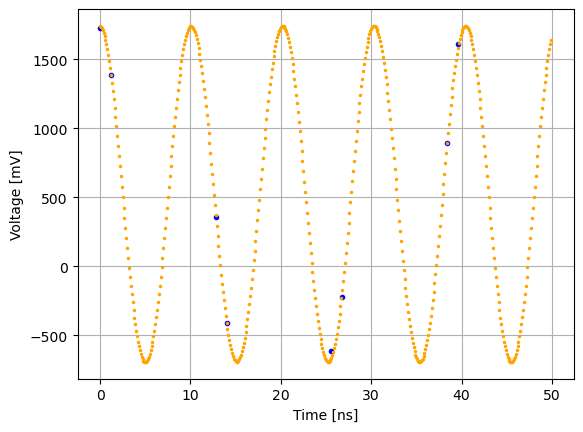

In [63]:
p1, _1 = curve_fit(sinewave, time_0_folded, cell_data[1][event_indices[0]*8:event_indices[0]*8+8], p0=[2500, 0.1, 0, 0])

A_fit1, f_fit1, phi_fit1, C_fit1 = p1
print(f"Fitted parameters: A={A_fit1:.3f}, f={f_fit1:.3f}, phi={phi_fit1:.3f}, C={C_fit1:.3f}")

plt.plot(time_0_folded, cell_data[1][event_indices[0]*8:event_indices[0]*8+8],'.', color='blue', label="Data")
plt.plot(time[:500], sinewave(time[:500], *p1),'.',markersize=3,color = 'orange', label="Fit")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]");
plt.grid()

print(sinewave(time_0_folded,*p1)[1])
print(cell_data[1][1280])

Same cell, different event

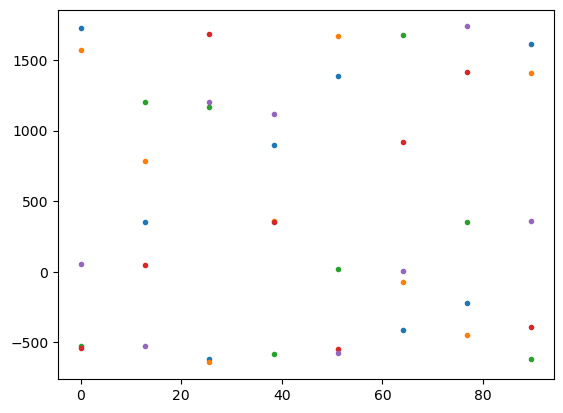

In [71]:
for ev in range(5):
    plt.plot(time_0, cell_data[1][event_indices[ev]*8:event_indices[ev]*8+8],'.')

Fitted parameters: A=1201.565, f=0.099, phi=1.193, C=507.691
369.39998863871347
1728.6


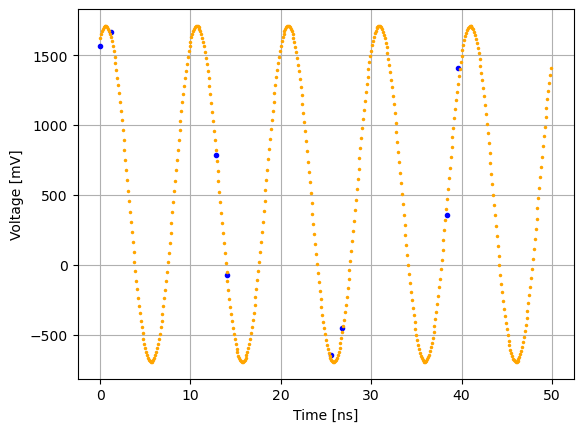

In [70]:
p2, _ = curve_fit(sinewave, time_0_folded, cell_data[1][event_indices[1]*8:event_indices[1]*8+8], p0=[2500, 0.1, 0, 0])

A_fit1, f_fit1, phi_fit1, C_fit1 = p2
print(f"Fitted parameters: A={A_fit1:.3f}, f={f_fit1:.3f}, phi={phi_fit1:.3f}, C={C_fit1:.3f}")

plt.plot(time_0_folded, cell_data[1][event_indices[1]*8:event_indices[1]*8+8],'.', color='blue', label="Data")
plt.plot(time[:500], sinewave(time[:500], *p2),'.',markersize=3,color = 'orange', label="Fit")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]");
plt.grid()

print(sinewave(time_0_folded,*p1)[1])
print(cell_data[1][1280])

* Now I want to draw linearity plot $\Rightarrow$ I need to figure out how to get the input voltge in this case